In [3]:
#LOADING DATASET

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

# Initialize Spark Session if not already created
spark = SparkSession.builder \
    .appName("BonusUserBehaviorEDA") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Path to the bonus dataset
bonus_file_path = "/kaggle/input/omp-serial-json"

# Define the schema (modify fields as per the actual bonus file structure)
bonus_schema = StructType([
    StructField("userID", StringType(), True),
    StructField("event", StringType(), True),      # e.g., 'click', 'view', 'add-to-cart'
    StructField("timestamp", TimestampType(), True)  # Timestamp of the event
])

# Read the bonus JSON file with the defined schema
bonus_df = spark.read.json(bonus_file_path, schema=bonus_schema, mode="DROPMALFORMED")

# Display a sample of the bonus data
bonus_df.show(5)


+------+-----+---------+
|userID|event|timestamp|
+------+-----+---------+
|  NULL| NULL|     NULL|
|  NULL| NULL|     NULL|
|  NULL| NULL|     NULL|
|  NULL| NULL|     NULL|
|  NULL| NULL|     NULL|
+------+-----+---------+
only showing top 5 rows



In [4]:
# Basic data cleaning (if necessary)
bonus_df_clean = bonus_df.dropna().dropDuplicates()


In [8]:
# Analyzing User Actions:

from pyspark.sql import functions as F

# Group by the event type and count occurrences
event_counts = bonus_df_clean.groupBy("event").count()
event_counts.show()


+-----+-----+
|event|count|
+-----+-----+
+-----+-----+



In [6]:
# Convert timestamp to date (for example, year-month)
bonus_df_time = bonus_df_clean.withColumn("event_date", F.from_unixtime(F.unix_timestamp("timestamp"), "yyyy-MM"))
events_per_month = bonus_df_time.groupBy("event_date", "event").count().orderBy("event_date")
events_per_month.show()


+----------+-----+-----+
|event_date|event|count|
+----------+-----+-----+
+----------+-----+-----+



**User Engagement Analysis**

In [7]:
# Group by userID to find top engaged users
top_users = bonus_df_clean.groupBy("userID").count().orderBy(F.desc("count")).limit(5)
top_users.show()


+------+-----+
|userID|count|
+------+-----+
+------+-----+



In [ ]:
# Assuming you have a DataFrame `df_final` from your main analysis,
# perform a join on user identifier if they match (reviewerID vs. userID).
combined_df = df_final.join(bonus_df_clean, df_final.reviewerID == bonus_df_clean.userID, "inner")
combined_df.show(5)

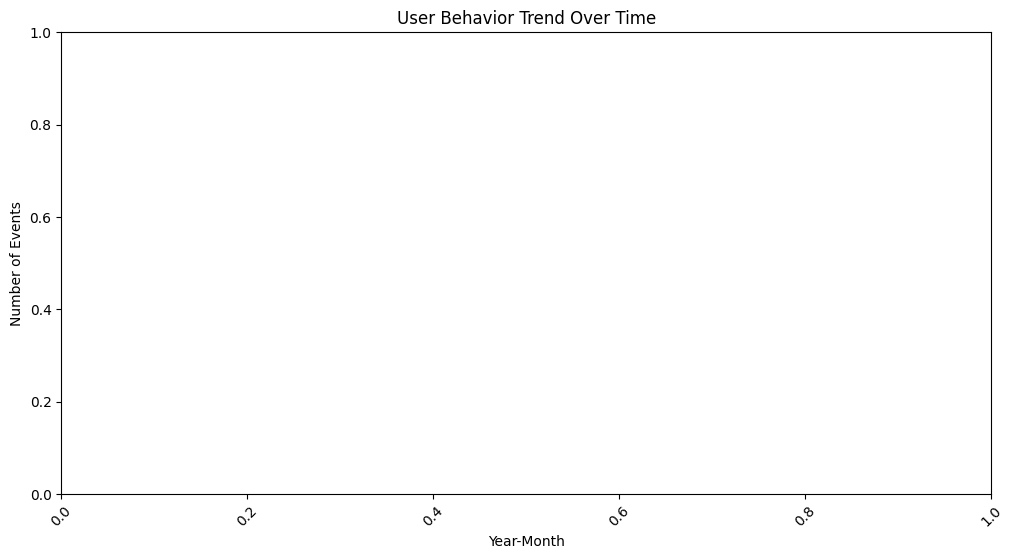

In [10]:
# Convert the monthly event counts to Pandas
events_per_month_pd = events_per_month.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(x="event_date", y="count", hue="event", data=events_per_month_pd, marker="o")
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Number of Events")
plt.title("User Behavior Trend Over Time")
plt.show()
